In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import re

In [2]:
def get_mods(df):
    #return df[np.logical_and(df["mod_name"]!="unmodified", df["type"]!="NL")]
    return df[df["mod_name"]!="unmodified"]

In [10]:
mods_abbrev_dict = {
    "Lysine,Acetyl": "K-acetyl",
    "Lysine,Formyl": "K-formyl",
    "Lysine,Biotin": "K-biotin",
    "Lysine,Methyl": "K-methyl",
    "Lysine,Carbamidomethyl": "K-carbami",
    "Lysine,Malonyl": "K-malonyl",
    "Lysine,Diethyl": "K-diethyl",
    "Lysine,Dimethyl": "K-dimethyl",
    "Proline,Oxidation": "P-oxid",
    "Tyrosine,Nitro": "Y-nitro",
    "Tyrosine,Phospho": "Y-phospho",
    "Arginine,Deamidated": "R-deamid",
    "Cysteine,Carbamidomethyl": "C-carbami",
    "Histidine,Carbamidomethyl": "H-carbami",
    "Tryptophan,Methyl": "W-methyl"   
}

In [3]:
mods_df = get_mods(pd.read_csv("../../data/result_csvs/230928_JL_Immonium_ions_Modified_DIA.mzML_diagnostic_ions_ppm_tolerance_10_snr_threshold_3_unimod.csv"))
unmods_df = get_mods(pd.read_csv("../../data/result_csvs/230928_JL_Immonium_ions_Unmodified_DIA.mzML_diagnostic_ions_ppm_tolerance_10_snr_threshold_3_unimod.csv"))

In [4]:
def get_mods_df_by_scan_window(result_df):
    mods_df = get_mods(result_df)[["spectrum_id", "amino_acid", "mod_name"]].drop_duplicates()
    return mods_df.groupby("spectrum_id")

In [5]:
get_mods(mods_df)[["spectrum_id", "letter_and_unimod_format_mod"]].drop_duplicates().groupby("spectrum_id")["letter_and_unimod_format_mod"].apply(list).to_frame()

,letter_and_unimod_format_mod
spectrum_id,
controllerType=0 controllerNumber=1 scan=100000,[Y(UniMod:21)]
controllerType=0 controllerNumber=1 scan=100048,"[K(UniMod:1), K(UniMod:122), K(UniMod:747), K(..."
controllerType=0 controllerNumber=1 scan=100049,"[K(UniMod:1), K(UniMod:4), K(UniMod:122), K(Un..."
controllerType=0 controllerNumber=1 scan=100050,"[R(UniMod:7), K(UniMod:1), K(UniMod:4), K(UniM..."
controllerType=0 controllerNumber=1 scan=100051,"[R(UniMod:7), K(UniMod:1), K(UniMod:4), K(UniM..."
...,...
controllerType=0 controllerNumber=1 scan=99994,"[K(UniMod:1), K(UniMod:122), K(UniMod:747), Y(..."
controllerType=0 controllerNumber=1 scan=99995,"[K(UniMod:1), K(UniMod:122), K(UniMod:747), Y(..."
controllerType=0 controllerNumber=1 scan=99996,"[K(UniMod:1), K(UniMod:747), Y(UniMod:21)]"


In [6]:
def get_mods_combinations_with_counts(
    detected_ions_df: pd.DataFrame, return_unimod=False
):
    mod_columns = (
        ["letter_and_unimod_format_mod"]
        if return_unimod
        else ["amino_acid", "mod_name"]
    )
    detected_ions_df_by_window = (
        detected_ions_df[["spectrum_id"] + mod_columns]
        .drop_duplicates()
        .groupby("spectrum_id")
    )

    mods = []
    for _, group in detected_ions_df_by_window:
        mods.append(
            [",".join(mod) for mod in (group[mod_columns].drop_duplicates().to_numpy())]
        )

    return np.unique(np.array(mods, dtype="object"), return_counts=True)

In [7]:
def get_mods_combinations_with_counts_subset(result_df, wanted_mods):
    mods_df_by_scan_window = get_mods_df_by_scan_window(result_df)

    mods = []
    for name, group in mods_df_by_scan_window:
        mods_in_group = [",".join(mod) for mod in group[["amino_acid", "mod_name"]].drop_duplicates().to_numpy() if ",".join(mod) in wanted_mods]
        if len(mods_in_group) > 0:
            mods.append(mods_in_group)

    return np.unique(np.array(mods, dtype='object'), return_counts=True)

In [8]:
def get_num_mods_per_scan_window(result_df):
    return get_mods_df_by_scan_window(result_df).count().rename(columns={"amino_acid": "count"})["count"]
    

In [9]:
def get_windows_single_multiple_mods(result_df):
    num_mods_df_by_scan_window = get_num_mods_per_scan_window(result_df)
    windows_multiple_mods = num_mods_df_by_scan_window[num_mods_df_by_scan_window != 1]
    windows_single_mods = num_mods_df_by_scan_window[num_mods_df_by_scan_window == 1]
    return windows_single_mods, windows_multiple_mods

In [11]:
len(get_mods_df_by_scan_window(mods_df)), len(get_mods_df_by_scan_window(unmods_df))

(36776, 20499)

In [12]:
all_mod_combinations, combination_counts = get_mods_combinations_with_counts(mods_df, return_unimod=False)

In [13]:
all_mod_combinations

array([list(['Arginine,Deamidated']),
       list(['Arginine,Deamidated', 'Cysteine,Carbamidomethyl', 'Lysine,Acetyl', 'Lysine,Carbamidomethyl', 'Lysine,Diethyl', 'Lysine,Formyl', 'Lysine,Malonyl', 'Lysine,Methyl', 'Proline,Oxidation', 'Tyrosine,Nitro', 'Tyrosine,Phospho']),
       list(['Arginine,Deamidated', 'Cysteine,Carbamidomethyl', 'Lysine,Acetyl', 'Lysine,Carbamidomethyl', 'Lysine,Formyl', 'Lysine,Malonyl', 'Proline,Oxidation', 'Tyrosine,Phospho']),
       list(['Arginine,Deamidated', 'Cysteine,Carbamidomethyl', 'Lysine,Acetyl', 'Lysine,Formyl', 'Lysine,Malonyl', 'Lysine,Methyl', 'Proline,Oxidation', 'Tyrosine,Phospho']),
       list(['Arginine,Deamidated', 'Cysteine,Carbamidomethyl', 'Lysine,Acetyl', 'Lysine,Formyl', 'Lysine,Malonyl', 'Proline,Oxidation', 'Tyrosine,Phospho']),
       list(['Arginine,Deamidated', 'Histidine,Carbamidomethyl', 'Histidine,Methyl', 'Lysine,Acetyl', 'Lysine,Carbamidomethyl', 'Lysine,Formyl', 'Lysine,Malonyl', 'Lysine,Methyl', 'Proline,Oxidation', 'Ty

In [28]:
[frozenset(combination) for combination in all_mod_combinations]

[frozenset({'Arginine,Deamidated'}),
 frozenset({'Arginine,Deamidated',
            'Cysteine,Carbamidomethyl',
            'Lysine,Acetyl',
            'Lysine,Carbamidomethyl',
            'Lysine,Diethyl',
            'Lysine,Formyl',
            'Lysine,Malonyl',
            'Lysine,Methyl',
            'Proline,Oxidation',
            'Tyrosine,Nitro',
            'Tyrosine,Phospho'}),
 frozenset({'Arginine,Deamidated',
            'Cysteine,Carbamidomethyl',
            'Lysine,Acetyl',
            'Lysine,Carbamidomethyl',
            'Lysine,Formyl',
            'Lysine,Malonyl',
            'Proline,Oxidation',
            'Tyrosine,Phospho'}),
 frozenset({'Arginine,Deamidated',
            'Cysteine,Carbamidomethyl',
            'Lysine,Acetyl',
            'Lysine,Formyl',
            'Lysine,Malonyl',
            'Lysine,Methyl',
            'Proline,Oxidation',
            'Tyrosine,Phospho'}),
 frozenset({'Arginine,Deamidated',
            'Cysteine,Carbamidomethyl',
    

In [14]:
all_mod_combinations_wanted, combination_counts_wanted = get_mods_combinations_with_counts_subset(
    mods_df, ['Lysine,Acetyl', 'Lysine,Biotin', 'Lysine,Dimethyl', 'Lysine,Methyl', 
              'Lysine,Trimethyl', 'Proline,Oxidation', 'Tyrosine,Nitro', 'Tyrosine,Phospho'])

In [18]:
all_mod_combinations_wanted

array([list(['Lysine,Acetyl']), list(['Lysine,Acetyl', 'Lysine,Biotin']),
       list(['Lysine,Acetyl', 'Lysine,Biotin', 'Lysine,Dimethyl', 'Lysine,Methyl', 'Proline,Oxidation', 'Tyrosine,Phospho']),
       list(['Lysine,Acetyl', 'Lysine,Biotin', 'Lysine,Dimethyl', 'Proline,Oxidation', 'Tyrosine,Phospho']),
       list(['Lysine,Acetyl', 'Lysine,Biotin', 'Lysine,Methyl']),
       list(['Lysine,Acetyl', 'Lysine,Biotin', 'Lysine,Methyl', 'Proline,Oxidation']),
       list(['Lysine,Acetyl', 'Lysine,Biotin', 'Lysine,Methyl', 'Proline,Oxidation', 'Tyrosine,Nitro']),
       list(['Lysine,Acetyl', 'Lysine,Biotin', 'Lysine,Methyl', 'Proline,Oxidation', 'Tyrosine,Nitro', 'Tyrosine,Phospho']),
       list(['Lysine,Acetyl', 'Lysine,Biotin', 'Lysine,Methyl', 'Proline,Oxidation', 'Tyrosine,Phospho']),
       list(['Lysine,Acetyl', 'Lysine,Biotin', 'Lysine,Methyl', 'Tyrosine,Nitro']),
       list(['Lysine,Acetyl', 'Lysine,Biotin', 'Lysine,Methyl', 'Tyrosine,Nitro', 'Tyrosine,Phospho']),
       list([

In [17]:
all_mod_combinations[-1], combination_counts[-1]

(['Y(UniMod:354)', 'Y(UniMod:21)'], 8)

In [ ]:
all_mod_combinations

In [ ]:
np.array([comb for comb in all_mod_combinations if len(comb) == 1])

In [15]:
all_unmod_combinations, unmod_combination_counts = get_mods_combinations_with_counts(unmods_df)
len(all_unmod_combinations)

313

In [52]:
def plot_combination_counts(combinations, counts, fig_name=None, plot_fractions=None, topk=None, figsize=(5, 15), xlim=None, line_label_pos_fraction = 3):
    count_sort = np.argsort(counts)
    all_mod_combinations_sorted = combinations[count_sort]
    combination_counts_sorted = counts[count_sort]
    total_count = combination_counts_sorted.sum()

    if topk is not None:
        all_mod_combinations_sorted = all_mod_combinations_sorted[-topk:]
        combination_counts_sorted = combination_counts_sorted[-topk:]

    fig, ax = plt.subplots(figsize=figsize)
    combination_names = [(r" $\bf{|}$ ").join([mods_abbrev_dict[mod] for mod in combination]) for combination in all_mod_combinations_sorted]
    num_combinations = len(combination_names)
    ax.bar_label(ax.barh(range(num_combinations), combination_counts_sorted), padding=3)
    ax.set_yticks(range(num_combinations), labels=combination_names)
    ax.set_ylim(-1, len(combination_names))
    ax.set_xlabel("Number of windows")
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.invert_yaxis()

    if plot_fractions is not None:
        combination_counts_sorted_reverse = combination_counts_sorted[::-1]
        max_count = combination_counts_sorted_reverse.max()
        color_map = cm.get_cmap("Dark2")

        for j, fraction in enumerate(plot_fractions):
            total_count_fraction = total_count * fraction
            print(total_count)
            print(total_count_fraction)
            total_count_current = 0

            for i, count in enumerate(combination_counts_sorted_reverse):
                total_count_current += count
                if total_count_current >= total_count_fraction:
                    print(i, count)
                    ax.axhline(num_combinations - (i + 1.5), label=fraction, color=color_map(j))
                    ax.text(max_count/line_label_pos_fraction,num_combinations - (i + 1.75), f"Count percentile\n   >= {fraction}", color=color_map(j))
                    break    

    if fig_name is not None:
        plt.savefig(f"../../data/plots/{fig_name}", bbox_inches="tight")

/tmp/ipykernel_24447/3915102697.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("Dark2")


36776
29420.800000000003
28 179
36776
33098.4
36776
34937.2


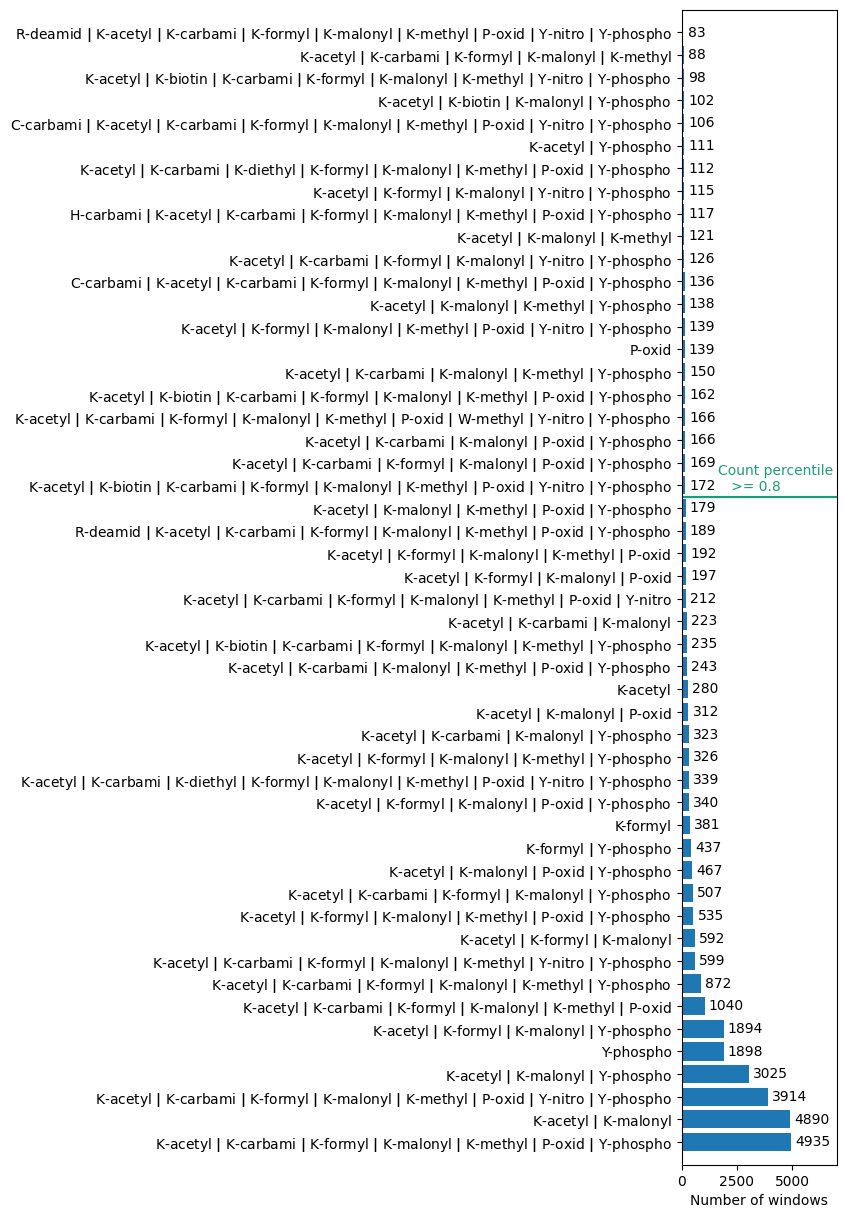

In [60]:
plot_combination_counts(all_mod_combinations, combination_counts, fig_name="num_combinations_sorted_snr3_10ppm_top50.svg", plot_fractions=[0.8, 0.9, 0.95], topk=50, figsize=(2, 15), xlim=(0, 7000))

/tmp/ipykernel_24447/3915102697.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap("Dark2")


36258
29006.4
6 1511
36258
32632.2
9 714
36258
34445.1
14 303


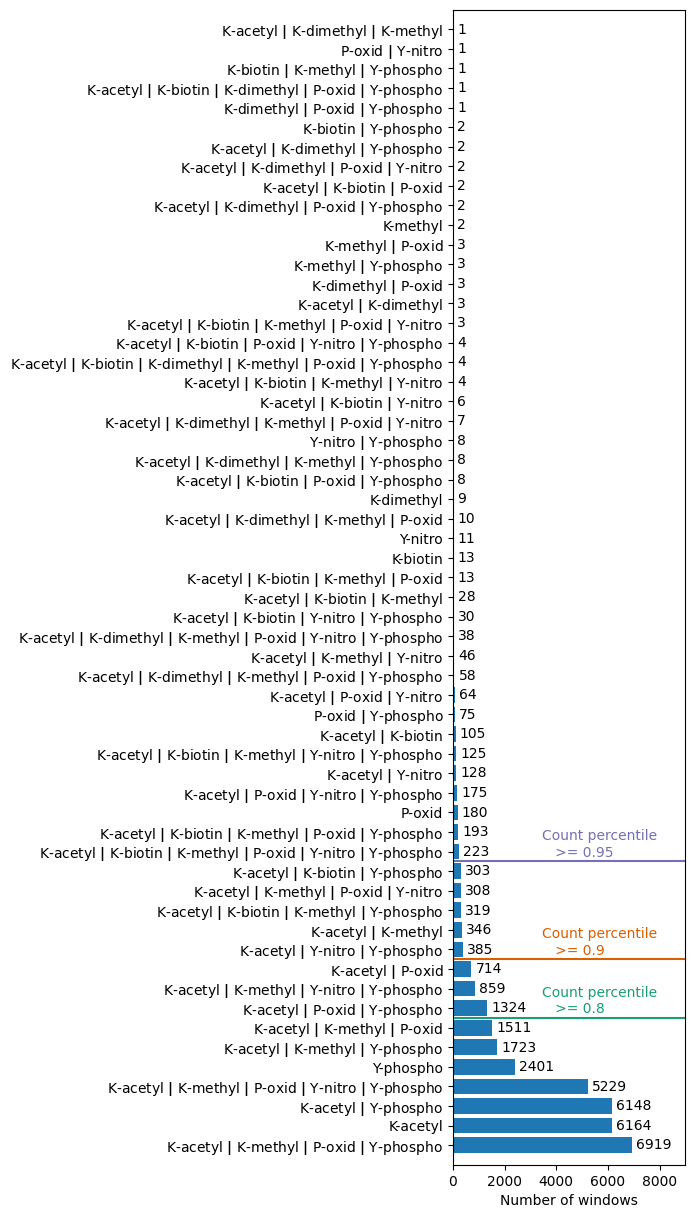

In [61]:
plot_combination_counts(all_mod_combinations_wanted, combination_counts_wanted, plot_fractions=[0.8, 0.9, 0.95], line_label_pos_fraction =2, figsize=(3, 15), xlim=(0, 9000), fig_name="num_combinations_sorted_snr3_10ppm_wanted_combinations.svg")

In [54]:
single_mod_combinations_idcs = [(idx, comb) for idx, comb in enumerate(all_mod_combinations_wanted) if len(comb) == 1]
single_mod_combinations = np.array([comb for idx, comb in single_mod_combinations_idcs])
single_mod_counts = np.array(combination_counts_wanted[[idx for idx, _ in single_mod_combinations_idcs]])
single_mod_counts.sum(), combination_counts_wanted.sum()

(8780, 36258)

In [183]:
single_mod_combinations

array([['Lysine,Acetyl'],
       ['Lysine,Biotin'],
       ['Lysine,Dimethyl'],
       ['Lysine,Methyl'],
       ['Proline,Oxidation'],
       ['Tyrosine,Nitro'],
       ['Tyrosine,Phospho']], dtype='<U17')

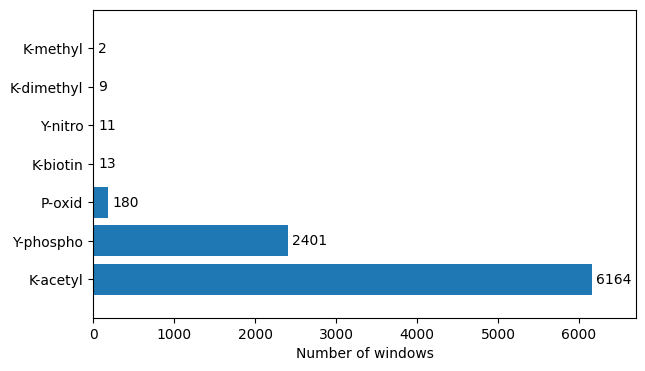

In [63]:
plot_combination_counts(single_mod_combinations, single_mod_counts, fig_name="num_combinations_sorted_snr3_10ppm_wanted_single.svg", figsize=(7, 4), xlim=(0, 6700))

In [ ]:
#plot_combination_counts(all_unmod_combinations, unmod_combination_counts, fig_name="num_combinations_unmod_sorted_snr3_5ppm_top20.png")

In [23]:
lb_ph_tp_combinations = [(idx, comb) for idx, comb in enumerate(all_mod_combinations) if np.all([mod in ["Proline,Hydroxylation", "Tyrosine,Phospho", "Lysine,Biotin"] for mod in comb])]
lb_ph_tp_combinations

[(599, ['Lysine,Biotin']),
 (603, ['Lysine,Biotin', 'Tyrosine,Phospho']),
 (642, ['Tyrosine,Phospho'])]

In [24]:
combination_counts[[idx for idx, _ in lb_ph_tp_combinations]][:-1].sum()

13

# Subsets of combinations appearing together

In [25]:
list(zip(all_mod_combinations, combination_counts))

[(['Arginine,Deamidated'], 11),
 (['Arginine,Deamidated',
   'Cysteine,Carbamidomethyl',
   'Lysine,Acetyl',
   'Lysine,Carbamidomethyl',
   'Lysine,Diethyl',
   'Lysine,Formyl',
   'Lysine,Malonyl',
   'Lysine,Methyl',
   'Proline,Oxidation',
   'Tyrosine,Nitro',
   'Tyrosine,Phospho'],
  1),
 (['Arginine,Deamidated',
   'Cysteine,Carbamidomethyl',
   'Lysine,Acetyl',
   'Lysine,Carbamidomethyl',
   'Lysine,Formyl',
   'Lysine,Malonyl',
   'Proline,Oxidation',
   'Tyrosine,Phospho'],
  1),
 (['Arginine,Deamidated',
   'Cysteine,Carbamidomethyl',
   'Lysine,Acetyl',
   'Lysine,Formyl',
   'Lysine,Malonyl',
   'Lysine,Methyl',
   'Proline,Oxidation',
   'Tyrosine,Phospho'],
  1),
 (['Arginine,Deamidated',
   'Cysteine,Carbamidomethyl',
   'Lysine,Acetyl',
   'Lysine,Formyl',
   'Lysine,Malonyl',
   'Proline,Oxidation',
   'Tyrosine,Phospho'],
  2),
 (['Arginine,Deamidated',
   'Histidine,Carbamidomethyl',
   'Histidine,Methyl',
   'Lysine,Acetyl',
   'Lysine,Carbamidomethyl',
   'Lysine

In [26]:
# based on https://stackoverflow.com/a/53887910

G_mods = nx.Graph()
for comb in all_mod_combinations[combination_counts > 1]:
    nx.add_path(G_mods, comb)

list(nx.connected_components(G_mods))

[{'Arginine,Deamidated',
  'Cysteine,Carbamidomethyl',
  'Histidine,Carbamidomethyl',
  'Histidine,Methyl',
  'Histidine,Oxidation',
  'Lysine,Acetyl',
  'Lysine,Biotin',
  'Lysine,Butyryl',
  'Lysine,Carbamidomethyl',
  'Lysine,Crotonyl',
  'Lysine,Diethyl',
  'Lysine,Dimethyl',
  'Lysine,Formyl',
  'Lysine,Glutarylation',
  'Lysine,Hex',
  'Lysine,Malonyl',
  'Lysine,Methyl',
  'Lysine,Propionyl',
  'Lysine,Succinyl',
  'Lysine,Thiazolidine',
  'Lysine,hydroxyisobutyryl',
  'Methionine,Dioxidation',
  'Proline,Oxidation',
  'Tryptophan,Methyl',
  'Tryptophan,Oxidation',
  'Tryptophan,Thiazolidine',
  'Tryptophan,Trp->Kynurenin',
  'Tyrosine,Nitro',
  'Tyrosine,Phospho'}]

In [44]:
list(zip(all_mod_combinations_wanted, combination_counts_wanted))

[(['Lysine,Acetyl'], 99),
 (['Lysine,Acetyl', 'Lysine,Biotin'], 2),
 (['Lysine,Acetyl',
   'Lysine,Biotin',
   'Proline,Hydroxylation',
   'Tyrosine,Nitro',
   'Tyrosine,Phospho'],
  1),
 (['Lysine,Acetyl', 'Lysine,Methyl'], 6),
 (['Lysine,Acetyl', 'Lysine,Methyl', 'Proline,Hydroxylation'], 92),
 (['Lysine,Acetyl',
   'Lysine,Methyl',
   'Proline,Hydroxylation',
   'Tyrosine,Nitro'],
  6),
 (['Lysine,Acetyl',
   'Lysine,Methyl',
   'Proline,Hydroxylation',
   'Tyrosine,Nitro',
   'Tyrosine,Phospho'],
  37),
 (['Lysine,Acetyl',
   'Lysine,Methyl',
   'Proline,Hydroxylation',
   'Tyrosine,Phospho'],
  202),
 (['Lysine,Acetyl', 'Lysine,Methyl', 'Tyrosine,Nitro'], 1),
 (['Lysine,Acetyl', 'Lysine,Methyl', 'Tyrosine,Nitro', 'Tyrosine,Phospho'], 3),
 (['Lysine,Acetyl', 'Lysine,Methyl', 'Tyrosine,Phospho'], 9),
 (['Lysine,Acetyl',
   'Lysine,di-Methylation',
   'Lysine,Methyl',
   'Proline,Hydroxylation',
   'Tyrosine,Nitro'],
  1),
 (['Lysine,Acetyl',
   'Lysine,di-Methylation',
   'Proline,H

In [27]:
# based on https://stackoverflow.com/a/53887910

G_mods_wanted = nx.Graph()
for comb in all_mod_combinations_wanted[combination_counts_wanted > 1]:
    nx.add_path(G_mods_wanted, comb)

list(nx.connected_components(G_mods_wanted))

[{'Lysine,Acetyl',
  'Lysine,Biotin',
  'Lysine,Dimethyl',
  'Lysine,Methyl',
  'Proline,Oxidation',
  'Tyrosine,Nitro',
  'Tyrosine,Phospho'}]

# Mods per scan window

([<matplotlib.axis.XTick at 0x7fa9cbaea5d0>,
 [Text(1, 0, 'mod'), Text(2, 0, 'unmod')])

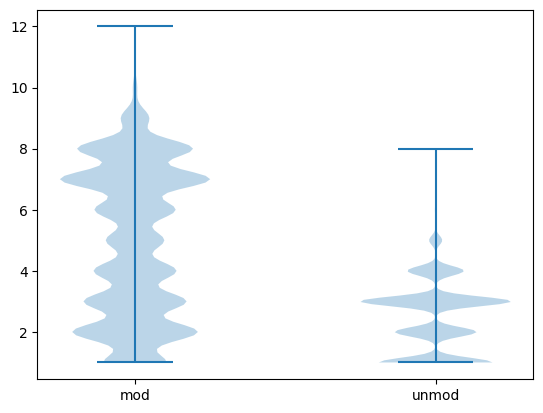

In [28]:
plt.violinplot([get_num_mods_per_scan_window(mods_df), get_num_mods_per_scan_window(unmods_df)])
plt.xticks([1, 2], labels=["mod", "unmod"])
#plt.savefig("../../data/plots/PTMs_per_scan_window_snr_3_5ppm.png")

# Phospo tyrosine and multiple combination counts

In [29]:
all_mod_combinations_multiple = [comb for comb in all_mod_combinations if len(comb) > 1]

In [30]:
len(all_mod_combinations_multiple)

626

In [31]:
combinations_phospho_tyrosine = [combination for combination in all_mod_combinations if "Tyrosine,Phospho" in combination]
combinations_phospho_tyrosine

[['Arginine,Deamidated',
  'Cysteine,Carbamidomethyl',
  'Lysine,Acetyl',
  'Lysine,Carbamidomethyl',
  'Lysine,Diethyl',
  'Lysine,Formyl',
  'Lysine,Malonyl',
  'Lysine,Methyl',
  'Proline,Oxidation',
  'Tyrosine,Nitro',
  'Tyrosine,Phospho'],
 ['Arginine,Deamidated',
  'Cysteine,Carbamidomethyl',
  'Lysine,Acetyl',
  'Lysine,Carbamidomethyl',
  'Lysine,Formyl',
  'Lysine,Malonyl',
  'Proline,Oxidation',
  'Tyrosine,Phospho'],
 ['Arginine,Deamidated',
  'Cysteine,Carbamidomethyl',
  'Lysine,Acetyl',
  'Lysine,Formyl',
  'Lysine,Malonyl',
  'Lysine,Methyl',
  'Proline,Oxidation',
  'Tyrosine,Phospho'],
 ['Arginine,Deamidated',
  'Cysteine,Carbamidomethyl',
  'Lysine,Acetyl',
  'Lysine,Formyl',
  'Lysine,Malonyl',
  'Proline,Oxidation',
  'Tyrosine,Phospho'],
 ['Arginine,Deamidated',
  'Histidine,Carbamidomethyl',
  'Histidine,Methyl',
  'Lysine,Acetyl',
  'Lysine,Carbamidomethyl',
  'Lysine,Formyl',
  'Lysine,Malonyl',
  'Lysine,Methyl',
  'Proline,Oxidation',
  'Tyrosine,Phospho'],
 

In [32]:
for mod, count in zip(*np.unique([mod for combination in combinations_phospho_tyrosine for mod in combination], return_counts=True)):
    print(mod, count)

Arginine,Deamidated 52
Cysteine,Carbamidomethyl 60
Histidine,Carbamidomethyl 65
Histidine,Methyl 11
Histidine,Oxidation 1
Lysine,Acetyl 418
Lysine,Biotin 66
Lysine,Butyryl 20
Lysine,Carbamidomethyl 275
Lysine,Crotonyl 16
Lysine,Diethyl 56
Lysine,Dimethyl 20
Lysine,Formyl 342
Lysine,Glutarylation 6
Lysine,Hex 18
Lysine,Malonyl 403
Lysine,Methyl 280
Lysine,Propionyl 3
Lysine,Succinyl 14
Lysine,Thiazolidine 29
Lysine,hydroxyisobutyryl 6
Methionine,Dioxidation 6
Methionine,Oxidation 3
Proline,Oxidation 246
Tryptophan,Methyl 92
Tryptophan,Oxidation 30
Tryptophan,Thiazolidine 34
Tryptophan,Trp->Kynurenin 3
Tyrosine,Nitro 165
Tyrosine,Phospho 435


In [33]:
len(combinations_phospho_tyrosine)

435